In [3]:
#type = Ignore
#Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from AEModel import AE, MyDataset,AE_T
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Reading Dataset

In [4]:
#Read files
cnv_df= pd.read_csv("../../data/master_cnv_df.csv",encoding = "UTF-8")


In [5]:
#type(gene_df.iloc[:,1:].shape[1])
cnv_df.iloc[:,1:].head()

,OR4F5,OR4F29,OR4F16,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,BPY2B,DAZ3,DAZ4,BPY2C,CDY1
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# DataLoader is used to load the dataset for training
pd_train_dataset, pd_test_dataset = train_test_split(cnv_df.iloc[:,1:], test_size=0.2)

X_train_sc = StandardScaler().fit_transform(pd_train_dataset)

X_test_sc = StandardScaler().fit_transform(pd_test_dataset)

X_full_sc = StandardScaler().fit_transform(cnv_df.iloc[:,1:])

In [7]:
data_train = MyDataset(X_train_sc)
data_test = MyDataset(X_test_sc)
data_full = MyDataset(X_full_sc)

In [8]:
train_loader=DataLoader(data_train, batch_size=50, shuffle=False)
test_loader = DataLoader(data_test, batch_size=50)

In [9]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE_T(input_shape = len(X_train_sc[0])).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [12]:
losses_train = []
losses_val = []

epochs=200
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        lol, outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses_train.append(loss)


    #For Valid Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            code, outputs = model(batch)
            loss_val =criterion(outputs, batch)
            val_loss += loss_val.item()

    val_loss = val_loss / len(test_loader)
    losses_val.append(val_loss)


    # display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, epochs, val_loss))

epoch : 1/200, train_loss = 0.209061
epoch : 1/200, val_loss = 0.249155
epoch : 2/200, train_loss = 0.208816
epoch : 2/200, val_loss = 0.248947
epoch : 3/200, train_loss = 0.208577
epoch : 3/200, val_loss = 0.248623
epoch : 4/200, train_loss = 0.208332
epoch : 4/200, val_loss = 0.248410
epoch : 5/200, train_loss = 0.208095
epoch : 5/200, val_loss = 0.248125
epoch : 6/200, train_loss = 0.207860
epoch : 6/200, val_loss = 0.248021
epoch : 7/200, train_loss = 0.207622
epoch : 7/200, val_loss = 0.247998
epoch : 8/200, train_loss = 0.207398
epoch : 8/200, val_loss = 0.248052
epoch : 9/200, train_loss = 0.207180
epoch : 9/200, val_loss = 0.247917
epoch : 10/200, train_loss = 0.206976
epoch : 10/200, val_loss = 0.247949
epoch : 11/200, train_loss = 0.206744
epoch : 11/200, val_loss = 0.248103
epoch : 12/200, train_loss = 0.206655
epoch : 12/200, val_loss = 0.247525
epoch : 13/200, train_loss = 0.206339
epoch : 13/200, val_loss = 0.247143
epoch : 14/200, train_loss = 0.206100
epoch : 14/200, va

KeyboardInterrupt: 

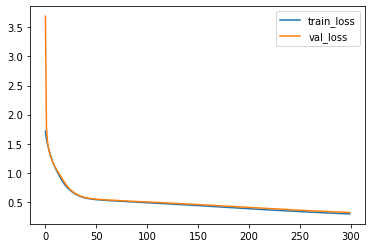

In [9]:
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.legend()

In [10]:
data = torch.tensor(X_full_sc,dtype=torch.float32)

In [11]:
# Full Gene Autoencoder Taining

data_full = MyDataset(X_full_sc)
full_loader = DataLoader(data_full, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE_T(input_shape = len(X_full_sc[0])).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.MSELoss()



In [12]:
losses_train_final = []

epochs=550
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in full_loader:
        batch_features = batch_features.to(device)
        
        optimizer.zero_grad()
        
        code, outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    losses_train_final.append(loss)

    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/550, train_loss = 2.119835
epoch : 2/550, train_loss = 1.940203
epoch : 3/550, train_loss = 1.824407
epoch : 4/550, train_loss = 1.721721
epoch : 5/550, train_loss = 1.629092
epoch : 6/550, train_loss = 1.544775
epoch : 7/550, train_loss = 1.465876
epoch : 8/550, train_loss = 1.392595
epoch : 9/550, train_loss = 1.325414
epoch : 10/550, train_loss = 1.263482
epoch : 11/550, train_loss = 1.205320
epoch : 12/550, train_loss = 1.152598
epoch : 13/550, train_loss = 1.104545
epoch : 14/550, train_loss = 1.061457
epoch : 15/550, train_loss = 1.023130
epoch : 16/550, train_loss = 0.989158
epoch : 17/550, train_loss = 0.958668
epoch : 18/550, train_loss = 0.931087
epoch : 19/550, train_loss = 0.905874
epoch : 20/550, train_loss = 0.883030
epoch : 21/550, train_loss = 0.862261
epoch : 22/550, train_loss = 0.843371
epoch : 23/550, train_loss = 0.826222
epoch : 24/550, train_loss = 0.810659
epoch : 25/550, train_loss = 0.796637
epoch : 26/550, train_loss = 0.784134
epoch : 27/550, train

In [13]:
model.eval()
with torch.no_grad():
    out,out2 = model(data)

In [14]:
latent_df = pd.DataFrame(out)
latent_df.insert(0,'file_name',cnv_df['file_name'])
latent_df

,file_name,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,41fc6849-724a-4bac-8775-5e703fe74184,0.617700,0.011123,1.709592,1.802925,0.864535,0.013604,1.251312,0.654158,0.529081,...,1.063729,-0.070066,-0.001569,-1.816005,1.563665,-2.394009,1.257136,0.394306,-1.513282,2.038277
1,0f6b347c-30da-495b-b103-36af30df77d7,0.701019,1.634090,1.713905,1.874578,0.944521,-1.083194,0.259510,0.460175,0.286948,...,1.075076,-0.890278,-0.679742,-1.816005,-0.602386,-2.748668,1.140180,0.989450,-1.030964,2.194542
2,6568ed2b-0018-4750-9b3b-6c414dba60ae,0.482779,0.834642,1.762489,1.899293,0.802337,-0.077112,-0.252213,0.776146,0.537715,...,0.965852,0.545567,1.027019,-1.816005,0.069231,-2.467926,1.354587,1.037515,-1.744227,1.812896
3,e18b7869-0049-4be7-9611-d08db28df33d,0.017044,-0.117965,1.499648,1.796704,0.022777,-0.707842,0.717963,-0.450479,-0.127403,...,0.703502,-0.826764,-0.335318,-0.642262,-0.153610,-2.529420,1.140180,0.609665,-1.030876,2.052207
4,361cc367-f85d-402a-a19d-999d33f7667a,-0.230597,0.136987,1.499648,1.796704,0.142297,-0.392801,0.524221,0.057456,-0.127403,...,0.753804,-1.121887,0.059129,-1.010980,-0.244771,-2.726314,1.140180,-0.026577,-0.617281,2.280982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,41811e19-d6bb-4f1c-ac67-9df06ad9f85b,0.104792,0.337378,1.499648,1.796704,-0.351197,-0.798211,-0.298172,-0.230740,-0.127403,...,0.574850,-1.200839,0.263114,-0.682506,-0.243005,-2.387605,1.140180,0.188272,-0.485411,2.426005
950,409bd257-5ce4-4a03-a7a8-c9c8e697fb39,0.054778,-0.184974,1.499648,1.796704,-0.171608,-0.950108,0.357520,-0.224926,-0.127403,...,0.667416,-1.235167,-0.071146,-0.727271,0.443232,-2.434762,1.140180,-0.457758,-0.794980,2.277326
951,d9e3e564-e9c8-416c-8a25-91e6744b1472,-0.080958,-0.737993,1.620272,1.800267,-0.261851,-0.587495,0.535072,-0.229857,0.078975,...,0.967174,-0.578166,0.023856,-0.754880,0.795938,-2.518502,1.140180,-0.697180,-1.034985,2.054563
952,fc1de880-73b1-4a71-a1e9-09c0591bfc8f,1.256258,1.991867,2.139649,2.798089,1.641920,1.495566,2.351040,2.038052,1.044466,...,1.062476,0.344642,1.344346,-1.816005,2.062183,-2.748668,2.164313,1.493201,-1.744227,3.016144


In [15]:
latent_df.to_csv("../../data/cnv_df_128_tw.csv", index=False)